# Algorithmic Trading with Deep Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
import yfinance as yf
import pandas_datareader as pdr
import tensorflow as tf

In [2]:
tickers_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers_data = tickers_data.rename(columns={'Symbol':'Ticker',
                                            'GICS Sector': 'Sector'})
tickers_data.loc[:,'Ticker'] = tickers_data.loc[:,'Ticker'].apply(lambda x:str(x).replace('.', '-' ))
tickers_data.head()

,Ticker,Security,Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
start = '2000-01-01'
end = '2020-01-01'

In [4]:
tickers = yf.Tickers(list(tickers_data.loc[:,'Ticker']))

data = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
data = data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


7 Failed downloads:
['OTIS', 'ABNB', 'CEG', 'CARR', 'GEHC', 'KVUE', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1577854800")


,Ticker,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume,Date
0,A,43.757744,51.502148,0.0,56.464592,48.193848,56.330471,0.0,4674353.0,2000-01-03
1,AAPL,0.847207,0.999442,0.0,1.004464,0.907924,0.936384,0.0,535796800.0,2000-01-03
2,ABT,9.081107,15.711531,0.0,16.160433,15.599306,15.823756,0.0,10635087.0,2000-01-03
3,ACGL,1.277778,1.277778,0.0,1.416667,1.263889,1.409722,0.0,433800.0,2000-01-03
4,ADBE,16.274673,16.390625,0.0,16.875000,16.062500,16.812500,0.0,7384400.0,2000-01-03


In [5]:
_open = data.pivot(index='Date', columns='Ticker', values='Open')
_open = _open.dropna(axis=1)
_open.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,56.330471,0.936384,15.823756,1.409722,16.812500,46.7500,10.884354,42.428928,8.500000,32.5625,...,68.375,1.887517,7.71875,71.0625,19.6250,39.75000,7.958333,6.930715,25.930555,59.03125
2000-01-04,48.730328,0.966518,15.459024,1.263889,15.750000,44.7500,10.714286,40.941933,8.046875,32.3125,...,65.500,1.854595,7.68750,69.7500,19.0625,38.68750,7.833333,6.649892,25.027779,54.62500
2000-01-05,47.389126,0.926339,15.066236,1.284722,14.562500,42.8125,10.770975,41.189766,7.750000,32.3125,...,63.875,1.711934,7.65625,67.2500,19.4375,39.00000,7.833333,6.604960,23.569445,52.75000
2000-01-06,44.080830,0.947545,15.262630,1.388889,15.359375,43.4375,10.544218,41.140202,7.375000,33.5625,...,63.000,1.733882,7.62500,71.1875,20.1250,40.31250,7.875000,6.560029,24.819445,52.75000
2000-01-07,42.247852,0.861607,15.487080,1.375000,15.390625,42.0000,10.770975,42.329796,7.015625,33.5000,...,64.500,1.733882,7.53125,72.0625,20.0000,42.96875,7.958333,6.548796,23.666668,53.75000


In [6]:
_adj_close = data.pivot(index='Date', columns='Ticker', values='Adj Close')
_adj_close = _adj_close.dropna(axis=1)
_adj_close.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.757744,0.847207,9.081107,1.277778,16.274673,28.706917,6.473896,25.075771,8.052907,10.858145,...,43.717709,1.238296,5.431209,11.691638,7.112459,18.499044,6.695477,4.725972,25.027779,36.146160
2000-01-04,40.415142,0.775779,8.821647,1.270833,14.909400,27.254671,6.406457,25.075771,7.660815,10.858145,...,42.081860,1.200194,5.487316,11.252419,7.276233,18.144707,6.695477,4.630974,24.666668,34.395832
2000-01-05,37.908188,0.787131,8.805431,1.388889,15.204173,27.652542,6.305304,24.834644,7.178246,11.278186,...,41.223064,1.181144,5.464875,11.848501,7.556990,19.133886,6.811223,4.654724,25.138889,34.355133
2000-01-06,36.464775,0.719014,9.113544,1.375000,15.328292,26.896578,6.339021,25.166183,6.740915,11.236184,...,41.672909,1.249727,5.408764,12.402756,7.486798,20.123062,6.820127,4.615142,23.777779,34.843597
2000-01-07,39.503513,0.753073,9.210839,1.451389,16.072985,27.652542,6.440176,25.738827,7.540174,11.404200,...,44.821903,1.230675,5.464875,11.994913,7.486798,20.063992,6.802316,4.512234,23.513889,34.924999


-----

In [6]:
#tickers.tickers['AAPL'].info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

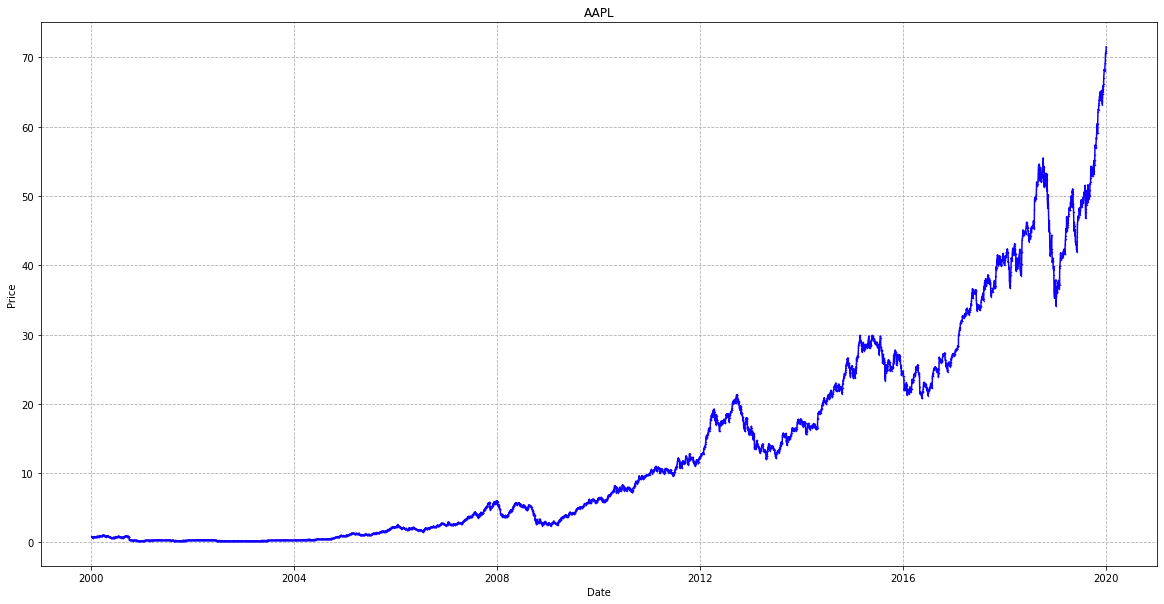

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('AAPL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.plot(_adj_close.index, _adj_close.loc[:,['AAPL']].values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

-----

In [8]:
returns = ((_adj_close - _adj_close.shift(1))/_adj_close.shift(1)).iloc[1:,:]
returns.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,-0.084310,-0.028571,-0.005435,-0.083889,-0.050589,-0.010417,0.000000,-0.048689,0.000000,...,-0.037418,-0.030770,0.010330,-0.037567,0.023026,-0.019154,0.000000,-0.020101,-0.014428,-0.048424
2000-01-05,-0.062030,0.014633,-0.001838,0.092897,0.019771,0.014598,-0.015789,-0.009616,-0.062992,0.038684,...,-0.020408,-0.015873,-0.004090,0.052974,0.038585,0.054516,0.017287,0.005129,0.019144,-0.001183
2000-01-06,-0.038077,-0.086538,0.034991,-0.010000,0.008163,-0.027338,0.005347,0.013350,-0.060925,-0.003724,...,0.010912,0.058065,-0.010267,0.046778,-0.009288,0.051698,0.001307,-0.008504,-0.054144,0.014218
2000-01-07,0.083334,0.047369,0.010676,0.055556,0.048583,0.028106,0.015957,0.022754,0.118568,0.014953,...,0.075565,-0.015244,0.010374,-0.032883,0.000000,-0.002935,-0.002612,-0.022298,-0.011098,0.002336
2000-01-10,0.060577,-0.017588,-0.007042,0.033493,0.038610,0.087050,0.000000,0.024590,-0.010099,-0.007366,...,-0.018248,-0.009288,0.020533,-0.004359,0.000000,-0.013980,0.023561,0.040350,0.033668,-0.018065


-----

In [9]:
split_date = '2016-01-01'

x_train = returns.loc[:split_date,:].values
x_test = returns.loc[split_date:,:].values

In [10]:
window_size = 20

X_train = []
Y_train = []
for i in range(x_train.shape[0]-window_size):
    X_train.append(x_train[i:i+window_size,:])
    Y_train.append(x_train[i+window_size,:])
X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')

X_test = []
Y_test = []
for i in range(x_test.shape[0]-window_size):
    X_test.append(x_test[i:i+window_size,:])
    Y_test.append(x_test[i+window_size,:])
X_test = np.array(X_test, dtype='float32')
Y_test = np.array(Y_test, dtype='float32')

In [11]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4004, 20, 362), (4004, 362), (986, 20, 362), (986, 362))

In [12]:
class PortfolioLayer(tf.keras.layers.Layer):
        
        def __init__(self, top, bottom):
            super().__init__()
            self.top = top
            self.bottom = bottom
                
        def call(self, inputs): 
            top_largest, _ = tf.math.top_k(inputs, k=self.top)
            sup = tf.reduce_min(top_largest, axis=1, keepdims=True)
            long = tf.math.sign(1. + tf.math.sign(inputs-sup))
            top_mask = long*inputs
            
            bottom_smallest, _ = tf.math.top_k(-inputs, k=self.bottom)
            bottom_smallest = -bottom_smallest
            inf = tf.reduce_max(bottom_smallest, axis=1, keepdims=True)
            short = tf.math.sign(1. + tf.math.sign(inf - inputs))
            bottom_mask = short*inputs
        
            portfolio = (top_mask+bottom_mask)/tf.reduce_sum(top_mask+bottom_mask, axis=1, keepdims=True)
            return portfolio

In [13]:
class TradingLostFunction(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        
    def call(self, y_true, y_pred):
        #return -tf.reduce_prod(tf.reduce_sum((1+y_true)*y_pred, axis=1), axis=0)
        #m = tf.reshape(tf.math.cumprod([1]+256*[0.2]), shape=(-1,1))
        #return -tf.reduce_sum(m*tf.reduce_sum(y_true*y_pred, axis=1), axis=0)
    
        return -tf.reduce_sum(tf.reduce_sum(y_true*y_pred, axis=1), axis=0)

In [14]:
def Model():
    f1 = tf.keras.layers.LSTM(units=64,
                              activation='tanh',
                              recurrent_activation='sigmoid',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros',
                              recurrent_initializer='zeros',
                              return_sequences=False,
                              return_state = False)
    f2 = tf.keras.layers.Dropout(rate=0.5)
    f3 = tf.keras.layers.Dense(units=64,
                              activation='tanh',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    f4 = tf.keras.layers.Dropout(rate=0.5)
    f5 = tf.keras.layers.Dense(units=Y_train.shape[1],
                              activation='linear',
                              kernel_initializer='glorot_uniform',
                              bias_initializer='zeros')
    f6 = PortfolioLayer(top=10,
                        bottom=10)  
    x = tf.keras.Input(shape=X_train.shape[1:])
    a1 = f1(x)
    a2 = f2(a1)
    a3 = f3(a2)
    a4 = f4(a3)
    a5 = f5(a4)
    y = f6(a5)
    model = tf.keras.Model(x, y) 
    loss = TradingLostFunction() 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    model.compile(loss=loss, 
                  optimizer=optimizer)
    model.summary()
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     patience=100,
                                                     min_delta=0.001,
                                                     factor=0.1, 
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=200,
                                                 min_delta=0.001)
    model.fit(X_train, 
              Y_train, 
              epochs=1, 
              batch_size=64, 
              callbacks=[callback1, callback2], 
              verbose=True)
    return model

In [15]:
model = Model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 362)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                109312    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 362)               23530     
                                                                 
 portfolio_layer (PortfolioL  (None, 362)              0     

2023-11-28 00:30:31.573385: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 2s 14ms/step - loss: 33.5819 - lr: 0.1000


In [16]:
model.save_weights('dl_algorithmic_trading')

-----

In [96]:
portfolio_positions = pd.DataFrame(model.predict(X_test),
                                   columns=returns.loc[split_date:,:].iloc[window_size:,:].columns,
                                   index=returns.loc[split_date:,:].iloc[window_size:,:].index)

portfolio_positions.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-02-03,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-02-04,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-02-05,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-02-08,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [97]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(986, 986.00024)

-----

In [98]:
mae = np.mean(np.linalg.norm(model.predict(X_train[1:,:])-model.predict(X_train[:-1,:]), ord=1, axis=1, keepdims=True))
std = np.std(np.linalg.norm(model.predict(X_train[1:,:])-model.predict(X_train[:-1,:]), ord=1, axis=1, keepdims=True))

In [99]:
signals = pd.DataFrame(np.linalg.norm(model.predict(X_test[1:,:])-model.predict(X_test[:-1,:]), ord=1, axis=1, keepdims=True),
                       columns=['signals'],
                       index=returns.loc[split_date:,:].iloc[window_size+1:,:].index)

signals.head()

,signals
Date,
2016-02-03,0.0
2016-02-04,0.0
2016-02-05,0.0
2016-02-08,0.0
2016-02-09,0.0


In [100]:
value = mae + 2*std

condition = 'signals > {}'.format(value)
portfolio_positions = pd.concat([portfolio_positions, signals], sort=False, axis=1).query(condition)
portfolio_positions = portfolio_positions.iloc[:,:-1]
portfolio_positions.head()

,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-02,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2016-03-03,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2018-12-27,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2018-12-28,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2019-01-07,0.134824,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.127968,...,0.186752,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [101]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(6, 6.0)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

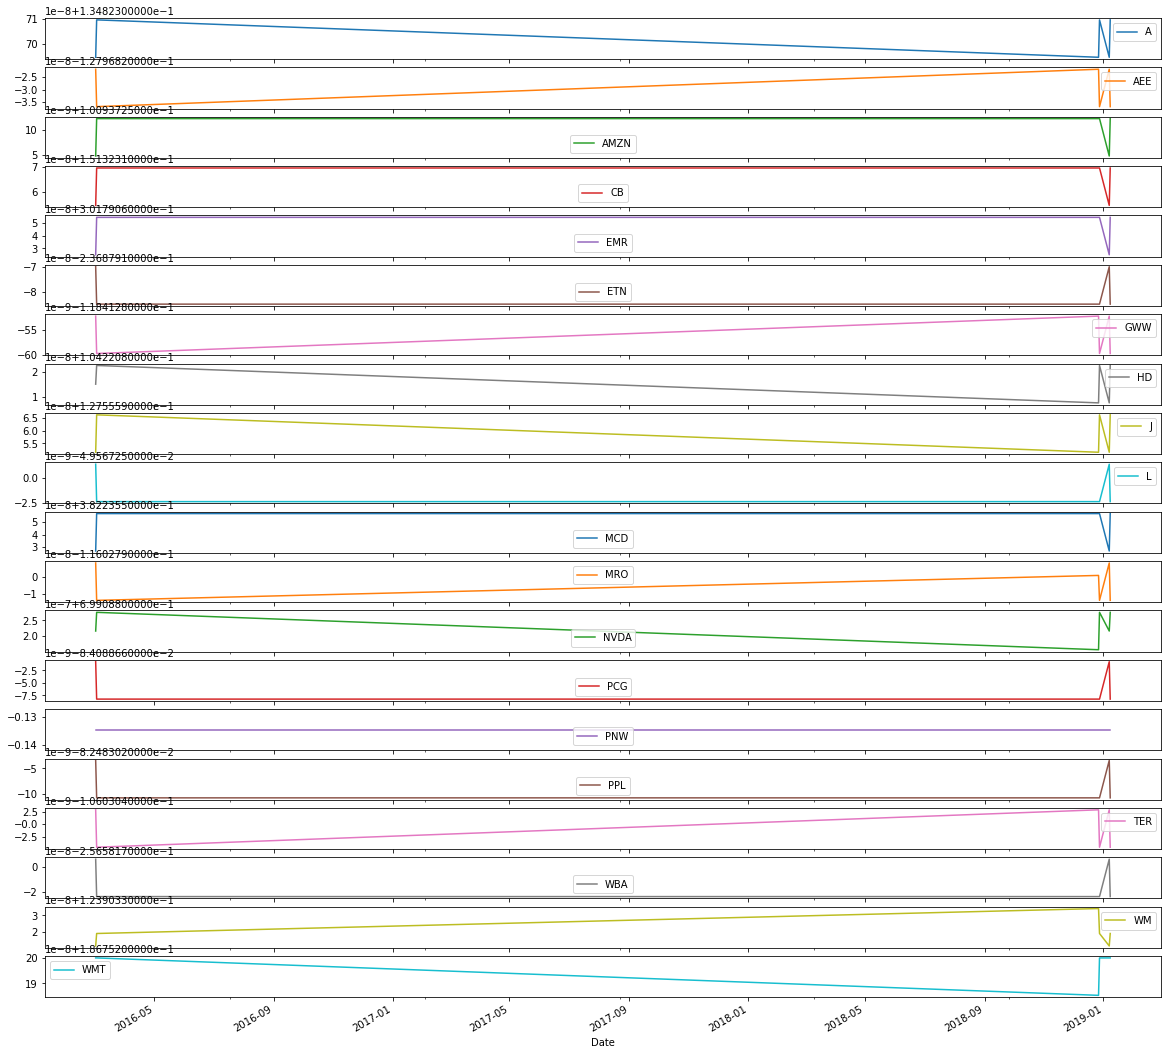

In [102]:
portfolio_positions.loc[:,list(portfolio_positions.describe().T.query('mean != 0.').T.columns)].plot(subplots=True, figsize=(20,20))

-----

In [85]:
trading_prices = _open.shift(-1).loc[portfolio_positions.index,:]
trading_prices.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-02,38.919998,25.145000,38.560001,23.026667,88.500000,55.610001,36.169998,84.849998,54.090000,46.980000,...,65.949997,23.577778,63.680000,27.309999,39.529999,82.660004,60.119999,54.299065,65.470001,22.799999
2016-03-03,39.139999,25.592501,38.849998,23.070000,87.930000,55.669998,36.900002,85.910004,55.250000,46.779999,...,66.139999,23.617779,64.129997,26.920000,39.349998,82.660004,60.220001,54.917328,66.529999,23.780001
2018-12-27,66.980003,39.375000,71.050003,26.549999,227.580002,85.489998,41.130001,130.089996,128.710007,65.430000,...,92.070000,32.488888,96.529999,21.639999,49.590000,69.180000,37.330002,91.580002,156.979996,40.669998
2018-12-28,66.339996,39.632500,71.570000,26.389999,225.559998,86.089996,40.840000,130.080002,129.190002,65.059998,...,92.669998,32.515556,96.980003,21.900000,49.349998,68.320000,37.279999,91.790001,157.070007,40.490002
2019-01-07,67.589996,37.389999,69.550003,26.420000,232.649994,84.269997,42.230000,131.479996,134.259995,64.019997,...,95.059998,32.288891,99.730003,23.580000,48.259998,72.540001,40.250000,91.669998,157.350006,43.310001


In [86]:
trading_returns = ((trading_prices - trading_prices.shift(1))/trading_prices.shift(1)).iloc[1:,:]
trading_returns.head()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-03,0.005653,0.017797,0.007521,0.001882,-0.006441,0.001079,0.020183,0.012493,0.021446,-0.004257,...,0.002881,0.001697,0.007067,-0.014280,-0.004554,0.000000,0.001663,0.011386,0.016191,0.042983
2018-12-27,0.711293,0.538537,0.828829,0.150845,1.588195,0.535657,0.114634,0.514259,1.329593,0.398675,...,0.392047,0.375611,0.505224,-0.196137,0.260229,-0.163078,-0.380106,0.667598,1.359537,0.710261
2018-12-28,-0.009555,0.006540,0.007319,-0.006026,-0.008876,0.007018,-0.007051,-0.000077,0.003729,-0.005655,...,0.006517,0.000821,0.004662,0.012015,-0.004840,-0.012431,-0.001339,0.002293,0.000573,-0.004426
2019-01-07,0.018842,-0.056582,-0.028224,0.001137,0.031433,-0.021141,0.034035,0.010763,0.039244,-0.015985,...,0.025790,-0.006971,0.028356,0.076712,-0.022087,0.061768,0.079667,-0.001307,0.001783,0.069647
2019-01-08,0.009025,0.011567,-0.008914,0.039743,0.005846,0.018393,0.011130,0.002890,0.003426,0.009685,...,0.006838,-0.001790,0.029881,0.000848,0.012640,0.000827,-0.018634,-0.000654,0.002796,0.000462


In [87]:
portfolio_returns = np.sum(trading_returns*portfolio_positions.shift(1).iloc[1:,:], axis=1)
portfolio_returns

Date
2016-03-03   -0.014807
2018-12-27    2.666103
2018-12-28    0.024350
2019-01-07    0.113210
2019-01-08   -0.029481
dtype: float64

<AxesSubplot:title={'center':'Portfolio Returns'}, ylabel='Density'>

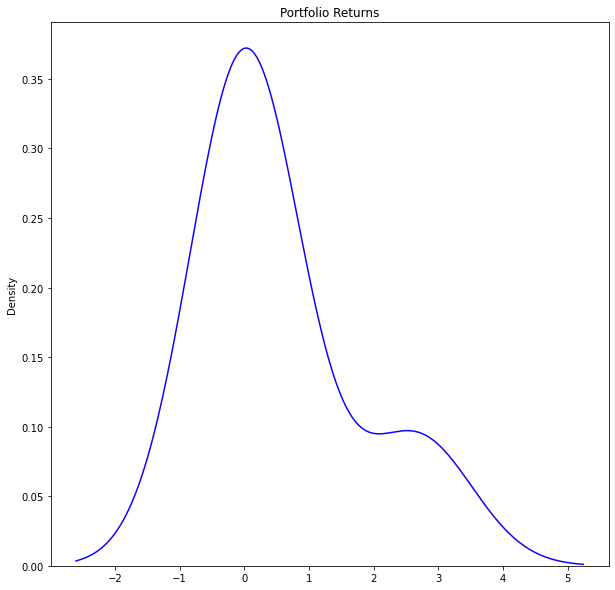

In [88]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Portfolio Returns')
sns.kdeplot(data=portfolio_returns, ax=ax, color='#0F00FF')

-----

In [89]:
discount_factor = np.cumprod(portfolio_returns+1)
discount_factor

Date
2016-03-03    0.985193
2018-12-27    3.611818
2018-12-28    3.699767
2019-01-07    4.118619
2019-01-08    3.997196
dtype: float64

In [90]:
start = portfolio_positions.index[0]
end = portfolio_positions.index[-1]

In [91]:
market_portfolio_positions = _adj_close.loc[start:end,:].div(_adj_close.loc[start:end,:].sum(axis=1), axis=0)
market_trading_prices = _open.shift(-1).loc[market_portfolio_positions.index,:]
market_trading_returns = ((market_trading_prices - market_trading_prices.shift(1))/market_trading_prices.shift(1)).iloc[1:,:]
market_portfolio_returns = np.sum(market_trading_returns*market_portfolio_positions.shift(1).iloc[1:,:], axis=1)
market_discount_factor = np.cumprod(market_portfolio_returns+1)

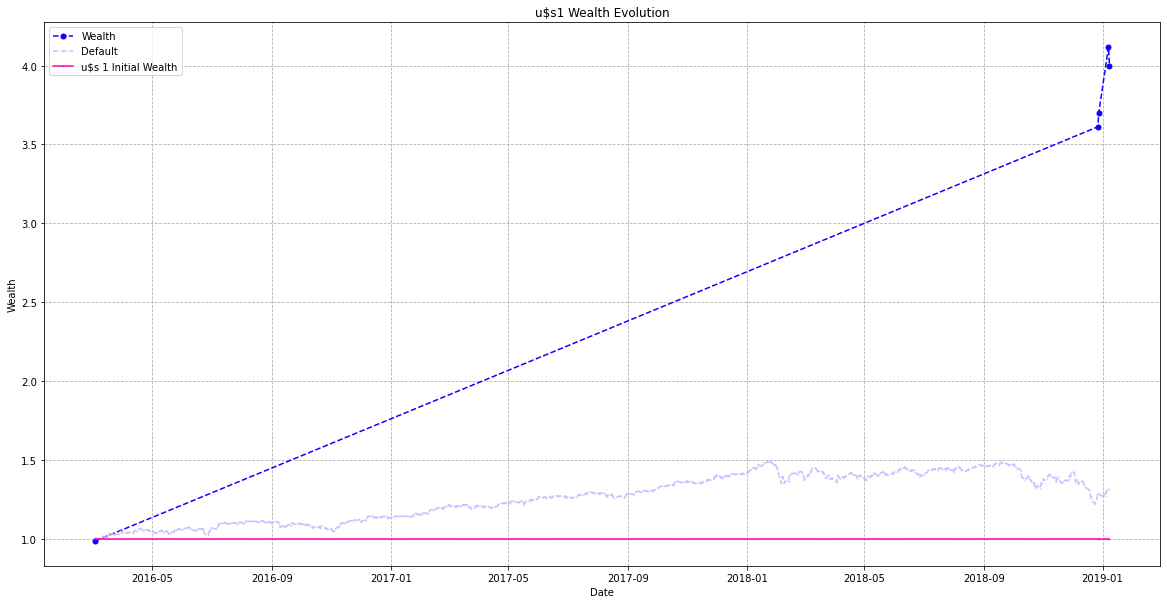

In [92]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('u$s1 Wealth Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.plot(discount_factor.index, discount_factor.values, marker='.', color='#0F00FF', markersize=10, linestyle='--', label='Wealth')
ax.plot(market_discount_factor.index, market_discount_factor.values, marker='.', color='#C7C3FF', markersize=1, linestyle='--', label='Default')
ax.plot(discount_factor.index, np.ones(discount_factor.shape), marker='.', color='#FF00AE', markersize=1, linestyle='-', label='u$s 1 Initial Wealth')
ax.legend()

In [30]:
portfolio_positions.to_csv('deeplearning_trading.csv')

-----

In [107]:
tickers = yf.Ticker("^GSPC")

sp500 = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
sp500 = sp500.loc[:,['Adj Close']]
sp500.head()

,Adj Close
Date,
2016-03-02 00:00:00-05:00,1986.449951
2016-03-03 00:00:00-05:00,1993.400024
2016-03-04 00:00:00-05:00,1999.989990
2016-03-07 00:00:00-05:00,2001.760010
2016-03-08 00:00:00-05:00,1979.260010


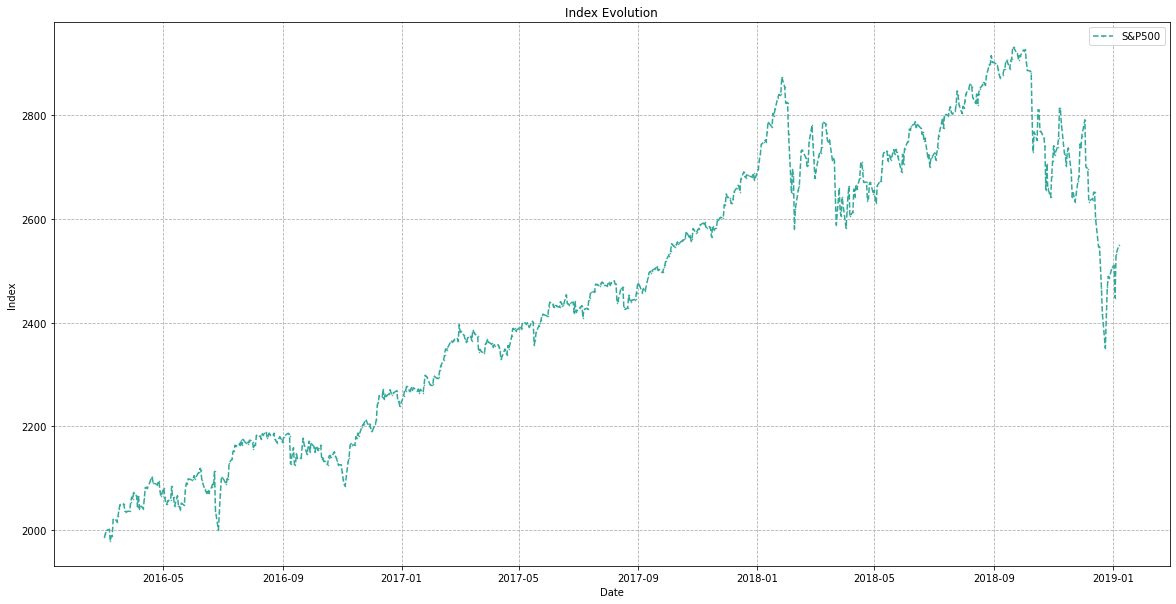

In [109]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('Index Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
ax.plot(sp500.index, sp500.loc[:,'Adj Close'].values, marker='.', color='#32A899', markersize=1, linestyle='--', label='S&P500')
ax.legend()